In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astropy.table import Table
from ipydatagrid import DataGrid
import pandas as pd
import ipywidgets as widgets
from ipydatagrid import DataGrid, TextRenderer

In [2]:
# Query the 'exoplanets' table to get data on all confirmed exoplanets
exoplanet_data = NasaExoplanetArchive.query_criteria(table="pscomppars", select="*")


In [3]:
# Convert to an Astropy Table
exoplanet_data = Table(exoplanet_data)

# Convert to a Pandas DataFrame
exoplanet_df = pd.DataFrame(np.array(exoplanet_data))

# Filter the DataFrame to include only the necessary columns
filtered_exoplanet_df = exoplanet_df[['hostname', 'sy_pnum', 'sy_snum', 'pl_orbper', 'st_met', 'pl_name', 'pl_rade'\
                                      , 'st_meterr1', 'st_meterr2', 'pl_orbpererr1', 'pl_orbpererr2'\
                                      , 'pl_radeerr1', 'pl_radeerr2'\
                                      , 'sy_pm', 'sy_pmerr1', 'sy_pmerr2', 'sy_dist', 'sy_disterr1', 'sy_disterr2'\
                                      , 'ra', 'dec'\
                                      , 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2'\
                                      , 'pl_masse', 'pl_masseerr1', 'pl_masseerr2'\
                                      , 'pl_trueobliq', 'pl_trueobliqerr1', 'pl_trueobliqerr2']]

# Create a new DataGrid for the filtered table
filtered_exoplanet_table = DataGrid(filtered_exoplanet_df, editable=False, layout={'height':'200px'})

# Create a search box
search_box = widgets.Text(
    value='',
    placeholder='Search for hostname',
    description='Search:',
    disabled=False
)

# Function to filter the DataFrame based on the search input
def filter_table(change):
    search_value = change['new']
    if search_value:
        df = filtered_exoplanet_df[filtered_exoplanet_df['hostname'].str.contains(search_value, case=False, na=True)]
    else:
        df = filtered_exoplanet_df
    filtered_exoplanet_table.data = df

# Attach the filter function to the search box
search_box.observe(filter_table, names='value')

# Display the search box and the new DataGrid
display(search_box, filtered_exoplanet_table)

Text(value='', description='Search:', placeholder='Search for hostname')

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [4]:
def check_and_replace_st_met(df):
    # Group by hostname
    grouped = df.groupby('hostname')
    
    for name, group in grouped:
        # Get unique st_met values, excluding NaNs
        unique_met_values = group['st_met'].dropna().unique()
        
        if len(unique_met_values) > 1:
            # Check if all values are within 0.01 of each other
            if np.all(np.abs(unique_met_values - unique_met_values.mean()) <= 0.01):
                # Average the values
                avg_met_value = unique_met_values.mean()
                df.loc[df['hostname'] == name, 'st_met'] = avg_met_value
            else:
                print(f"Warning: Discrepancy in st_met values for {name}: {unique_met_values}")
        
        # Replace NaNs with the first available st_met value
        if len(unique_met_values) > 0:
            df.loc[df['hostname'] == name, 'st_met'] = df.loc[df['hostname'] == name, 'st_met'].fillna(unique_met_values[0])
    
    return df

# Filter out systems with one star that have more than one metallicity value
def filter_discrepant_monostar_systems(df):
    grouped = df.groupby('hostname')
    to_remove = []
    
    for name, group in grouped:
        if group['sy_snum'].iloc[0] == 1:  # Only consider monostar systems
            unique_met_values = group['st_met'].dropna().unique()
            if len(unique_met_values) > 1 and not np.all(np.abs(unique_met_values - unique_met_values.mean()) <= 0.01):
                to_remove.append(name)
    
    return df[~df['hostname'].isin(to_remove)]

# Average metallicity values for monostar systems and create a new column with the range (max - min)
def process_monostar_systems(df):
    grouped = df.groupby('hostname')
    new_rows = []
    
    for name, group in grouped:
        if group['sy_snum'].iloc[0] == 1:  # Only consider monostar systems
            metallicity_values = group['st_met'].dropna()
            if len(metallicity_values) > 1:
                avg_met = metallicity_values.mean()
                met_range = metallicity_values.max() - metallicity_values.min()
                group['st_met'] = avg_met
                group['st_met_range'] = met_range
            elif len(metallicity_values) == 1:
                group['st_met_range'] = 0  # No range if there's only one value
            else:
                group['st_met_range'] = np.nan  # No metallicity values available
        else:
            group['st_met_range'] = np.nan  # Not applicable for multi-star systems
        
        new_rows.append(group)
    
    return pd.concat(new_rows)

def process_planet_entries(df):
    # Group by pl_name
    grouped = df.groupby('pl_name')
    new_rows = []
    
    for name, group in grouped:
        # Calculate average and range for orbital periods, ignoring NaNs
        orbital_periods = group['pl_orbper'].dropna()
        if len(orbital_periods) > 1:
            avg_orbper = orbital_periods.mean()
            orbper_range = orbital_periods.max() - orbital_periods.min()
            group['pl_orbper'] = avg_orbper
            group['pl_orbper_range'] = orbper_range
        else:
            group['pl_orbper_range'] = 0  # No range if there's only one value or all are NaNs
        
        new_rows.append(group.iloc[0])  # Keep only the first entry per group
    
    return pd.DataFrame(new_rows)


In [5]:
# Apply the function to check and replace st_met values
filtered_exoplanet_df = check_and_replace_st_met(filtered_exoplanet_df)
filtered_exoplanet_df = process_monostar_systems(filtered_exoplanet_df)
filtered_exoplanet_df = filtered_exoplanet_df.dropna(subset=['st_met'])
toy_df = filtered_exoplanet_df.copy()
filtered_exoplanet_df = filtered_exoplanet_df[(filtered_exoplanet_df['sy_pnum'] >= 3) & (filtered_exoplanet_df['sy_pnum'] <= 8)]


# Apply the function to the DataFrame
filtered_exoplanet_df = process_planet_entries(filtered_exoplanet_df)


# Split into different DataFrames based on the number of stars (sy_snum)
monostar_systems_df = filtered_exoplanet_df[filtered_exoplanet_df['sy_snum'] == 1]
duostar_systems_df = filtered_exoplanet_df[filtered_exoplanet_df['sy_snum'] == 2]
tristar_systems_df = filtered_exoplanet_df[filtered_exoplanet_df['sy_snum'] == 3]

In [6]:
# Create a DataGrid for the processed table with custom column widths
column_widths = {
    'pl_name': 150,
    'hostname': 150,
    'st_met': 100,
    'sy_pnum': 100,
    'sy_snum': 100,
    'pl_orbper': 100,
    'pl_orbper_range': 100
}

# Create a DataGrid for the filtered table
filtered_exoplanet_table_grid = DataGrid(filtered_exoplanet_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)

print(f"Number of rows: {filtered_exoplanet_df.shape[0]}")
filtered_exoplanet_table_grid

Number of rows: 1110


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [7]:
# Create a DataGrid for the filtered table
monostar_systems_grid = DataGrid(monostar_systems_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)
print(f"Number of rows: {monostar_systems_df.shape[0]}")
monostar_systems_grid

Number of rows: 985


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [8]:
# Create a DataGrid for the filtered table
tristar_systems_grid = DataGrid(tristar_systems_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)
print(f"Number of rows: {tristar_systems_df.shape[0]}")
tristar_systems_grid

Number of rows: 20


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [9]:
# Get unique star names for each DataFrame
unique_monostar_names = monostar_systems_df['hostname'].unique().tolist()
unique_duostar_names = duostar_systems_df['hostname'].unique().tolist()
unique_tristar_names = tristar_systems_df['hostname'].unique().tolist()

# Display the unique star names
unique_star_names = [unique_monostar_names, unique_duostar_names, unique_tristar_names]

for i, names in enumerate(unique_star_names):
    print(f"\n{len(unique_star_names[i])} Unique star names in {i+1} systems:")
    print(names)


281 Unique star names in 1 systems:
['47 UMa', '61 Vir', 'AU Mic', 'CoRoT-7', 'K2-16', 'EPIC 206024342', 'EPIC 249893012', 'GJ 1061', 'GJ 163', 'GJ 3138', 'GJ 3293', 'GJ 357', 'GJ 367', 'GJ 433', 'GJ 581', 'GJ 876', 'GJ 9827', 'HD 10180', 'HD 108236', 'HD 11506', 'HD 134606', 'HD 136352', 'HD 141399', 'HD 160691', 'HD 164922', 'HD 181433', 'HD 184010', 'HD 191939', 'HD 204313', 'HD 20794', 'HD 215152', 'HD 219134', 'HD 22946', 'HD 23472', 'HD 27894', 'HD 28109', 'HD 31527', 'HD 3167', 'HD 33142', 'HD 34445', 'HD 37124', 'HD 39091', 'HD 39194', 'HD 40307', 'HD 42813', 'HD 48948', 'HD 63433', 'HD 69830', 'HD 7924', 'HD 93385', 'HD 96700', 'HIP 14810', 'HIP 41378', 'HIP 57274', 'HR 8799', 'K2-138', 'K2-155', 'K2-165', 'K2-183', 'K2-187', 'K2-19', 'K2-198', 'K2-219', 'K2-233', 'K2-239', 'K2-268', 'K2-285', 'K2-3', 'K2-352', 'K2-368', 'K2-37', 'K2-381', 'K2-384', 'K2-58', 'K2-80', 'KIC 10001893', 'KOI-7892', 'KOI-142', 'Kepler-324', 'Kepler-968', 'KOI-351', 'Kepler-10', 'Kepler-100', 'Kepl

In [10]:
# Define a function to calculate the gap complexity for a given planetary system
from typing import List
import numpy as np

def gap_complexity(n: int, periods: List[float]) -> float:
    ''' 
    Calculate the gap complexity for a given planetary system.

    INPUTS
    ------
    n : int
        Number of planets in the system
    periods : List[float]
        Array of planet periods in increasing order

    OUTPUTS
    -------
    C : float
        Gap complexity of the system
    
    NOTES
    -----
    For planet periods, Gilbert & Fabrycky (2020) define gap complexity as:

    .. math::

        C = -K \left( \sum_{i=1}^{n-1} p_i^* \ln p_i^* \right) \left( \sum_{i=1}^{n-1} \left(p_i^* - \frac{1}{n-1}\right)^2 \right),

    .. math::

        p_i^* = \frac{\ln(P_{i+1}/P_i)}{\ln(P_n/P_1)},

    where `n` is the number of planets in the system, the ratio of periods for each adjacent planet pair is `P_{i+1}/P_i`, and the outermost and innermost planet periods are `P_n` and `P_1`. `K` is the normalization constant, which varies based on planet multiplicity and is given as `K=1/C_{max}`, where `C_{max}=[0.105, 0.212, 0.291, 0.350, 0.398, 0.437]`, respectively, for each multiplicity from 3- to 8-planet.
    '''
    
    # Calculate K based on stellar multiplicity
    C_max = np.array([0.105, 0.212, 0.291, 0.350, 0.398, 0.437])
    multiplicity = np.arange(3, 9)
    keyed_K = dict(zip(multiplicity, 1.0 / C_max))
    K = keyed_K[n]

    # Calculate pi_star
    pi_stars = np.zeros(n - 1)
    for i in range(n - 1):
        pi_stars[i] = np.log(periods[i + 1] / periods[i]) / np.log(periods[-1] / periods[0])

    # Calculate gap complexity (C)
    C = -K * np.sum(pi_stars * np.log(pi_stars)) * np.sum((pi_stars - 1 / (n - 1)) ** 2)  

    return C

In [11]:
# Initialize a dictionary to store the results
gap_complexity_results = []

# Calculate gap complexity for each star system
for star in unique_monostar_names:
    # Extract the periods for the current star system
    star_system = monostar_systems_df[monostar_systems_df['hostname'] == star]
    periods = star_system['pl_orbper'].values
    metallicity = star_system['st_met'].values[0]  # Assuming metallicity is the same for all entries of the same star

    # Sort the periods in increasing order
    periods = np.sort(periods)
    
    # Get the number of planets in the system
    n = star_system['sy_pnum'].values[0]
    
    # Check if the number of periods matches the number of planets
    if len(periods) != n:
        print(f"Skipping star {star} due to mismatch in number of periods and planets.")
        continue
    
    # Calculate the gap complexity
    C = gap_complexity(n, periods)
    
    # Store the result
    gap_complexity_results.append({'hostname': star, 'gap_complexity': C, 'st_met': metallicity})

# Convert the results to a DataFrame for better readability
monostar_gap_complexity_df = pd.DataFrame(gap_complexity_results)

# Merge the gap complexity results with the original DataFrame
monostar_systems_df = monostar_systems_df.merge(monostar_gap_complexity_df, on=['hostname', 'st_met'], how='left')

# Define custom column widths
column_widths = {
    'hostname': 200,
    'gap_complexity': 200,
    'st_met': 200
}

# Create a DataGrid for the gap complexity results
gap_complexity_grid = DataGrid(monostar_gap_complexity_df, editable=False, layout={'height': '400px'}, column_widths=column_widths)

# Display the DataGrid
display(gap_complexity_grid)

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'hostname': 200, 'gap…

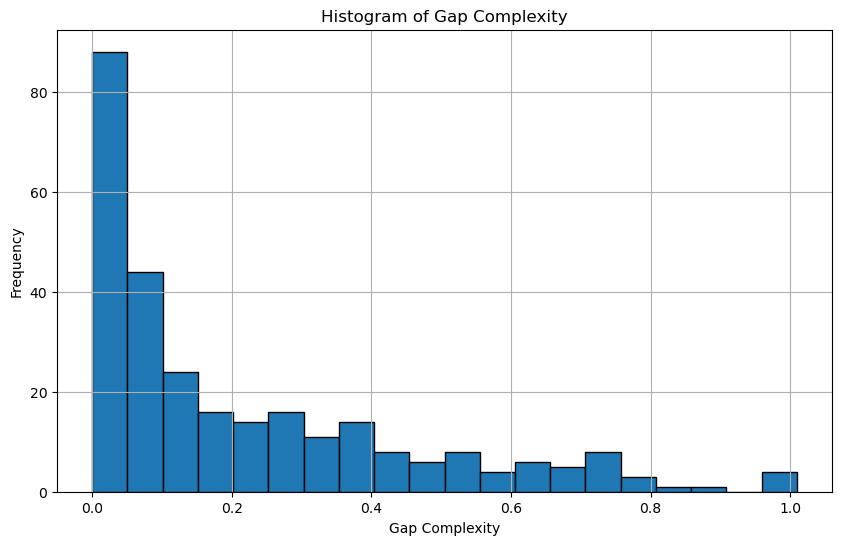

In [12]:
# Extract the gap complexity values
gap_complexity_values = monostar_gap_complexity_df['gap_complexity']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(gap_complexity_values, bins=20, edgecolor='black')
plt.title('Histogram of Gap Complexity')
plt.xlabel('Gap Complexity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

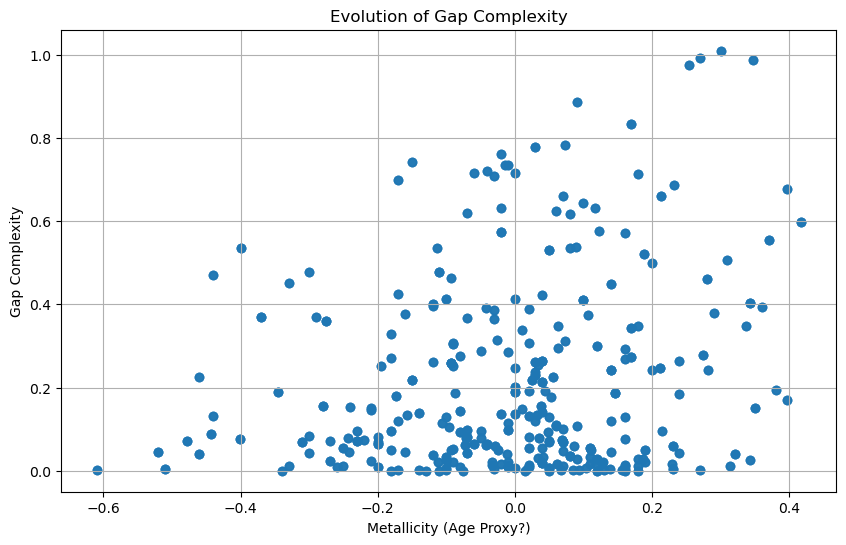

In [13]:
# Plot metallicity vs gap complexity with colors based on radius
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['st_met'], monostar_systems_df['gap_complexity'], alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.xlabel('Metallicity (Age Proxy?)')
plt.ylabel('Gap Complexity')
plt.grid(True)
#plt.gca().invert_xaxis()  # Reverse the x-axis direction

plt.show()

Is this a thing? Does the gap complexity start of uniform and decay with age? Or is this some kind of selection bias?

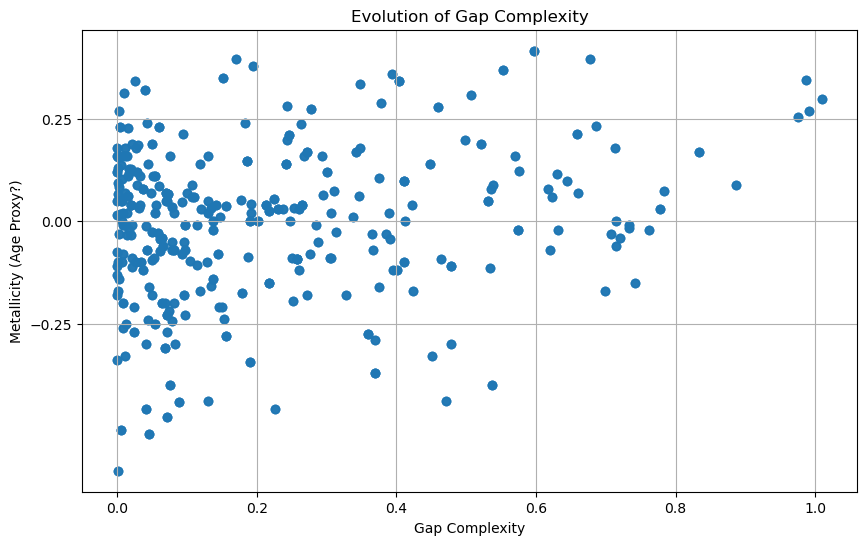

In [14]:
# Plot metallicity vs gap complexity with colors based on radius
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['gap_complexity'], monostar_systems_df['st_met'], alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.ylabel('Metallicity (Age Proxy?)')
plt.xlabel('Gap Complexity')
plt.grid(True)

# Set y-tick labels to 0.25, 0, and -0.25
plt.yticks([0.25, 0, -0.25])

plt.show()

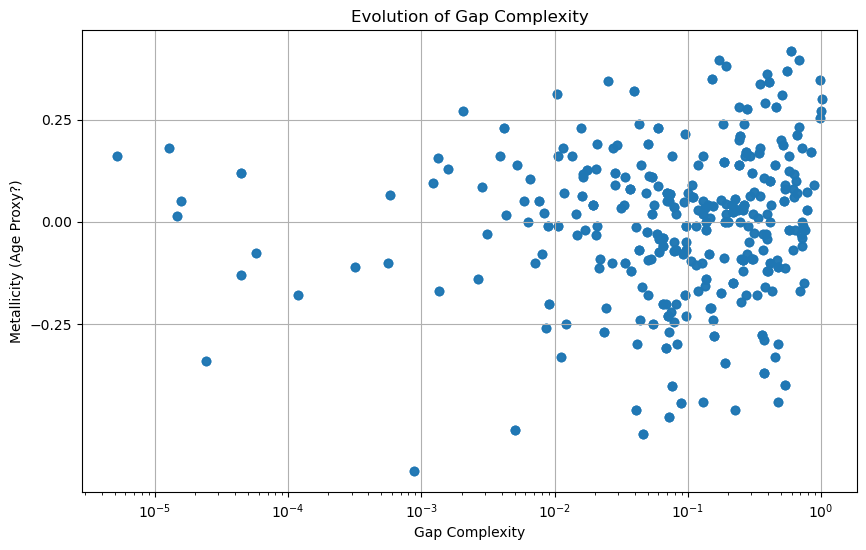

In [15]:
# Plot metallicity vs gap complexity with colors based on radius
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['gap_complexity'], monostar_systems_df['st_met'], alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.ylabel('Metallicity (Age Proxy?)')
plt.xlabel('Gap Complexity')
plt.grid(True)

# Set x-axis to log scale
plt.xscale('log')

# Set y-tick labels to 0.25, 0, and -0.25
plt.yticks([0.25, 0, -0.25])

plt.show()

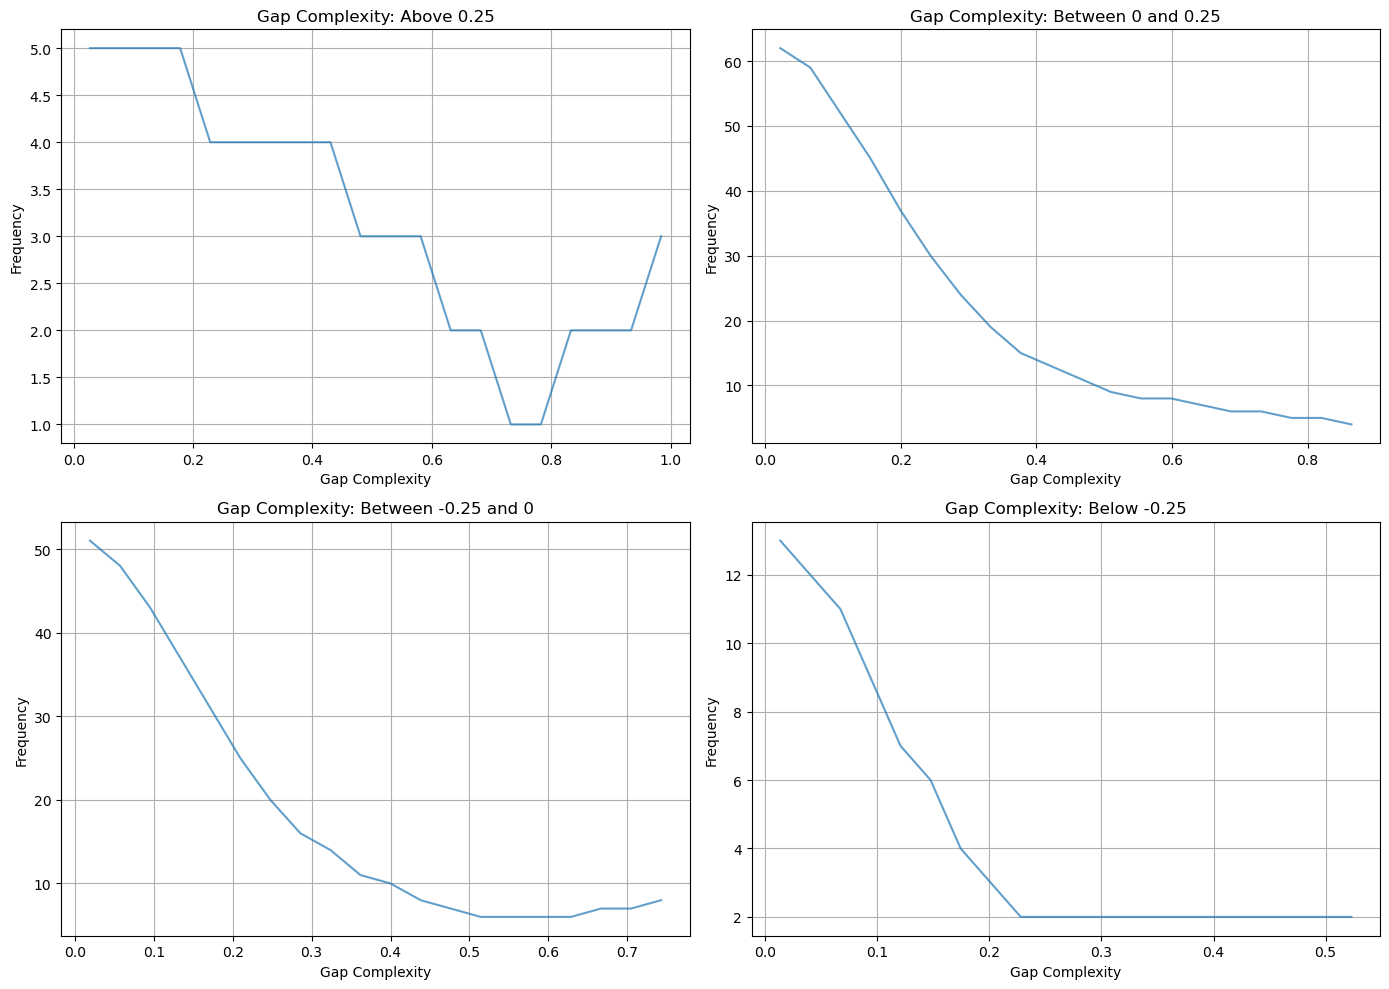

In [16]:
from scipy.ndimage import gaussian_filter1d

# Define the metallicity ranges
ranges = [
    ('Above 0.25', monostar_systems_df[monostar_systems_df['st_met'] > 0.25]),
    ('Between 0 and 0.25', monostar_systems_df[(monostar_systems_df['st_met'] <= 0.25) & (monostar_systems_df['st_met'] > 0)]),
    ('Between -0.25 and 0', monostar_systems_df[(monostar_systems_df['st_met'] <= 0) & (monostar_systems_df['st_met'] > -0.25)]),
    ('Below -0.25', monostar_systems_df[monostar_systems_df['st_met'] <= -0.25])
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot histograms for each range
for ax, (title, data) in zip(axs.flatten(), ranges):
    counts, bins = np.histogram(data['gap_complexity'], bins=20)
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=3)
    
    ax.plot(bins_center, smoothed_counts, alpha=0.7)
    ax.set_title(f'Gap Complexity: {title}')
    ax.set_xlabel('Gap Complexity')
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

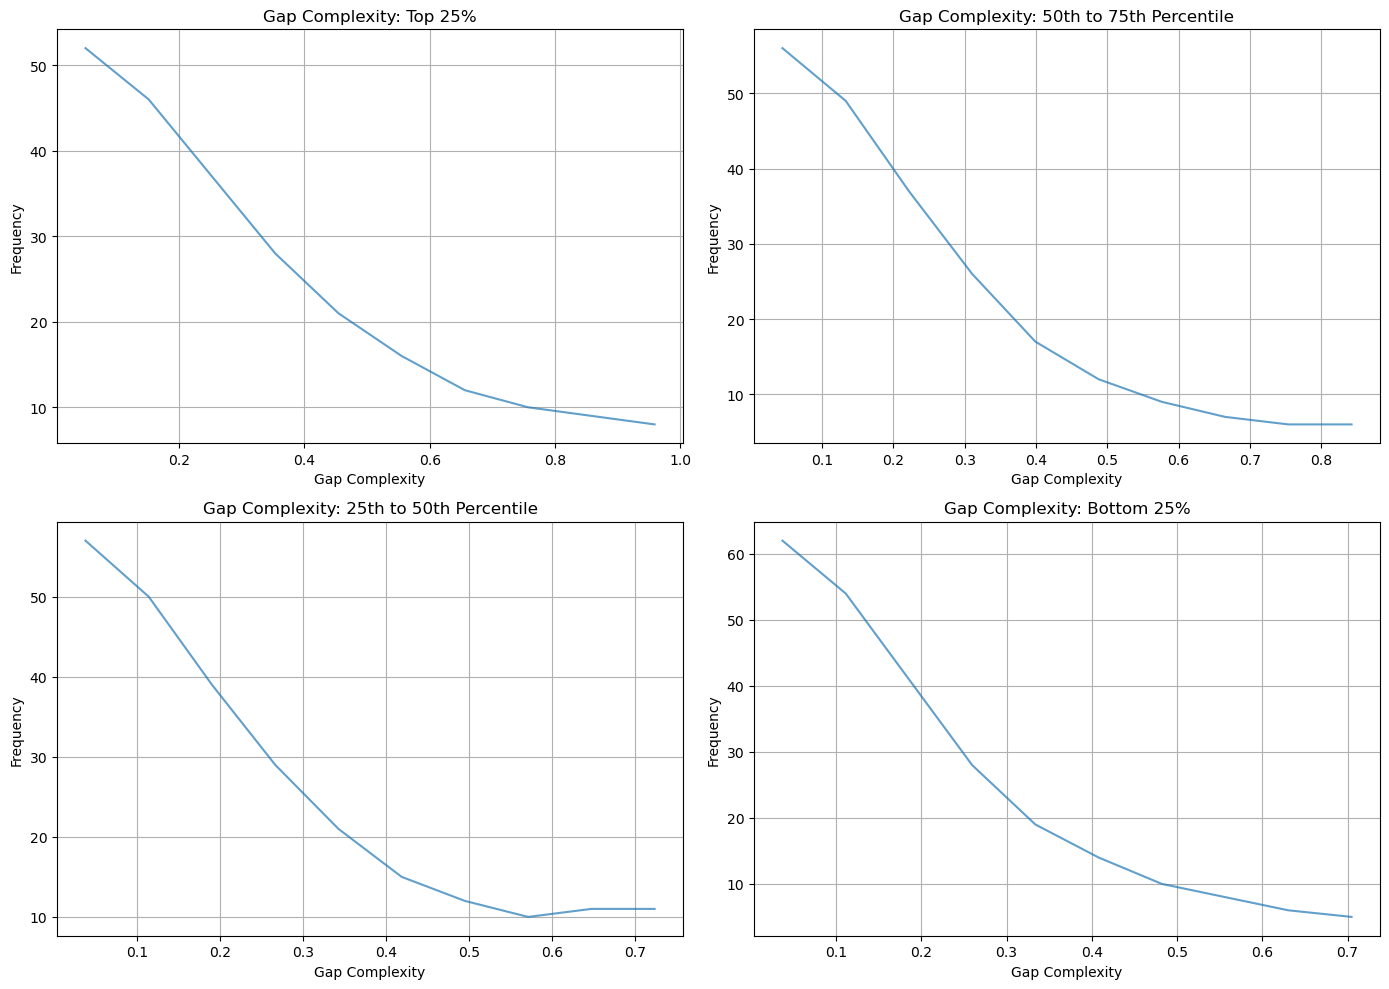

In [17]:
# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot histograms for each range
for ax, (title, data) in zip(axs.flatten(), ranges):
    counts, bins = np.histogram(data['gap_complexity'], bins=10)
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    ax.plot(bins_center, smoothed_counts, alpha=0.7)
    ax.set_title(f'Gap Complexity: {title}')
    ax.set_xlabel('Gap Complexity')
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/TheGuide/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


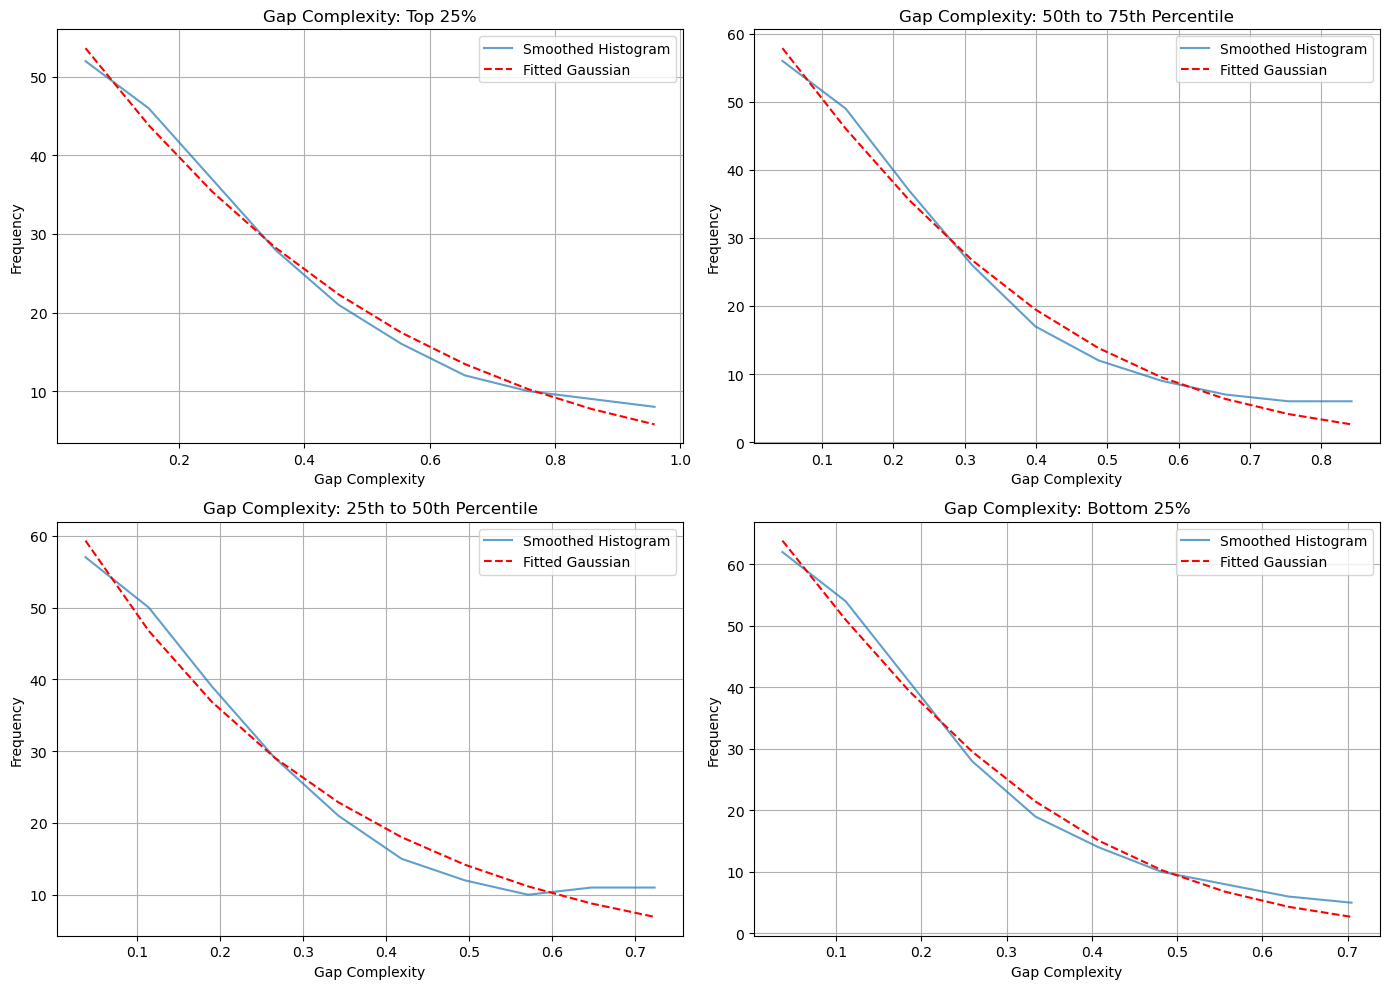

In [18]:
from scipy.optimize import curve_fit

# Define a Gaussian function
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# List to store the results
results = []

# Plot histograms for each range
for ax, (title, data) in zip(axs.flatten(), ranges):
    counts, bins = np.histogram(data['gap_complexity'], bins=10)
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.mean(bins_center), np.std(bins_center)], 
        bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]), 
        method='trf', 
        maxfev=100000
    )

    # Store the results
    results.append({'Range': title, 'Mean': popt[1], 'Stddev': popt[2]})
    
    # Plot the smoothed histogram data
    ax.plot(bins_center, smoothed_counts, alpha=0.7, label='Smoothed Histogram')
    
    # Plot the fitted Gaussian
    ax.plot(bins_center, gaussian(bins_center, *popt), 'r--', label='Fitted Gaussian')
    
    ax.set_title(f'Gap Complexity: {title}')
    ax.set_xlabel('Gap Complexity')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

                     Range       Mean    Stddev
0                  Top 25%  -1.670658  0.941061
1  50th to 75th Percentile  -0.609793  0.520551
2  25th to 50th Percentile -76.319634  4.946599
3               Bottom 25%  -0.450953  0.416052


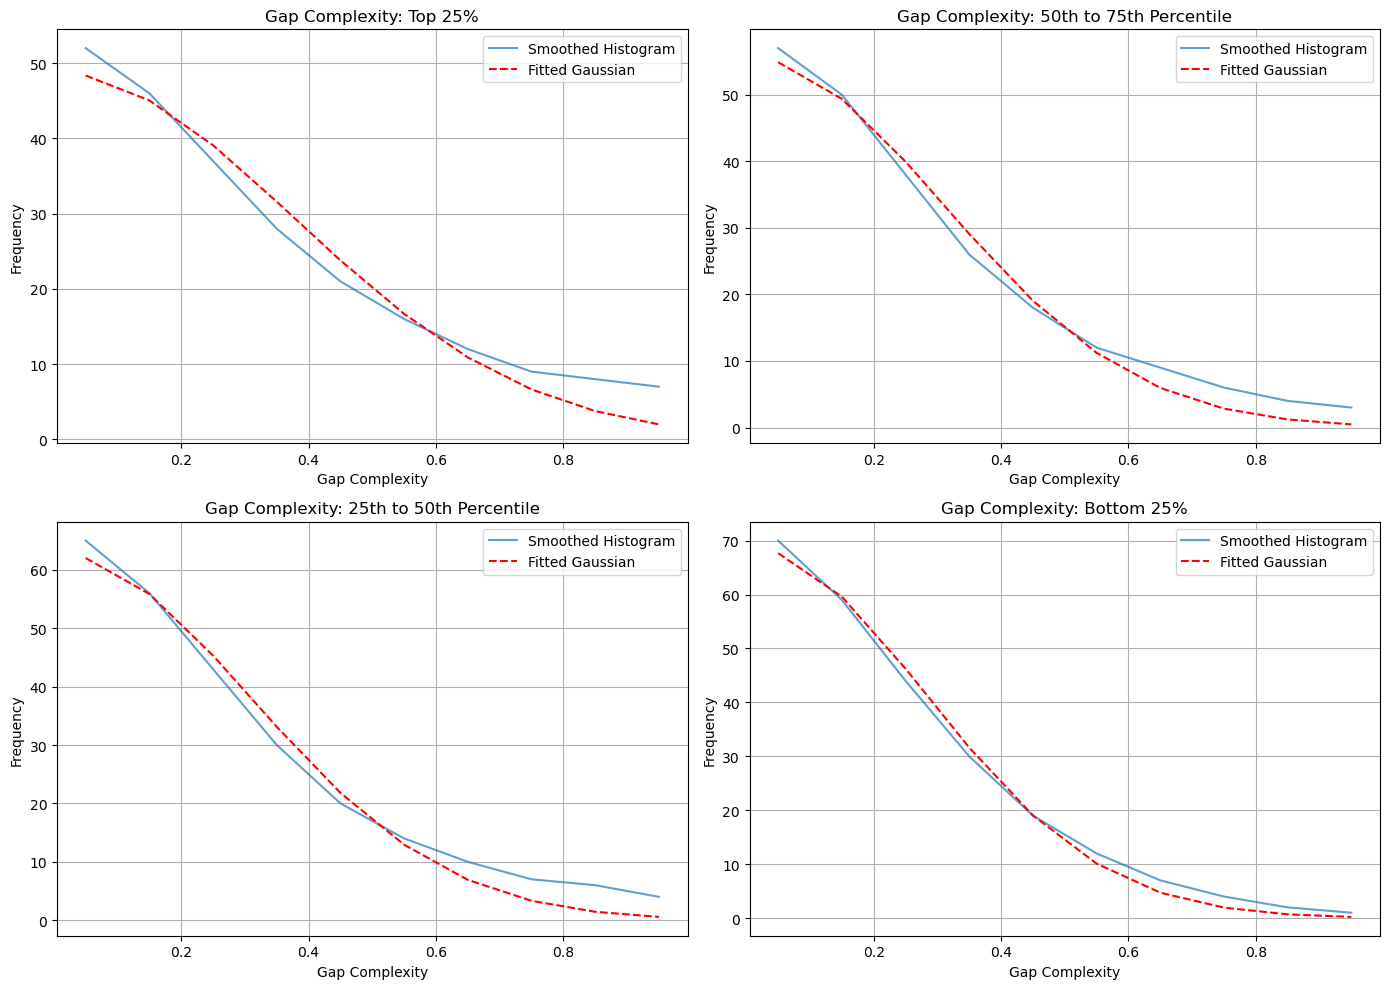

                     Range  Mean    Stddev
0                  Top 25%     0  0.375375
1  50th to 75th Percentile     0  0.307360
2  25th to 50th Percentile     0  0.309274
3               Bottom 25%     0  0.280847


In [20]:
# Define a Gaussian function with mean fixed at 0
def gaussian_fixed_mean(x, amp, stddev):
    mean = 0
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# List to store the results
results = []

# Plot histograms for each range
for ax, (title, data) in zip(axs.flatten(), ranges):
    counts, bins = np.histogram(data['gap_complexity'], bins=10, range=(0,1))
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian with mean fixed at 0 to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian_fixed_mean, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.std(bins_center)], 
        bounds=([0, 0], [np.inf, np.inf]), 
        method='trf', 
        maxfev=100000
    )
    
    # Store the results
    results.append({'Range': title, 'Mean': 0, 'Stddev': popt[1]})
    
    # Plot the smoothed histogram data
    ax.plot(bins_center, smoothed_counts, alpha=0.7, label='Smoothed Histogram')
    
    # Plot the fitted Gaussian
    ax.plot(bins_center, gaussian_fixed_mean(bins_center, *popt), 'r--', label='Fitted Gaussian')
    
    ax.set_title(f'Gap Complexity: {title}')
    ax.set_xlabel('Gap Complexity')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

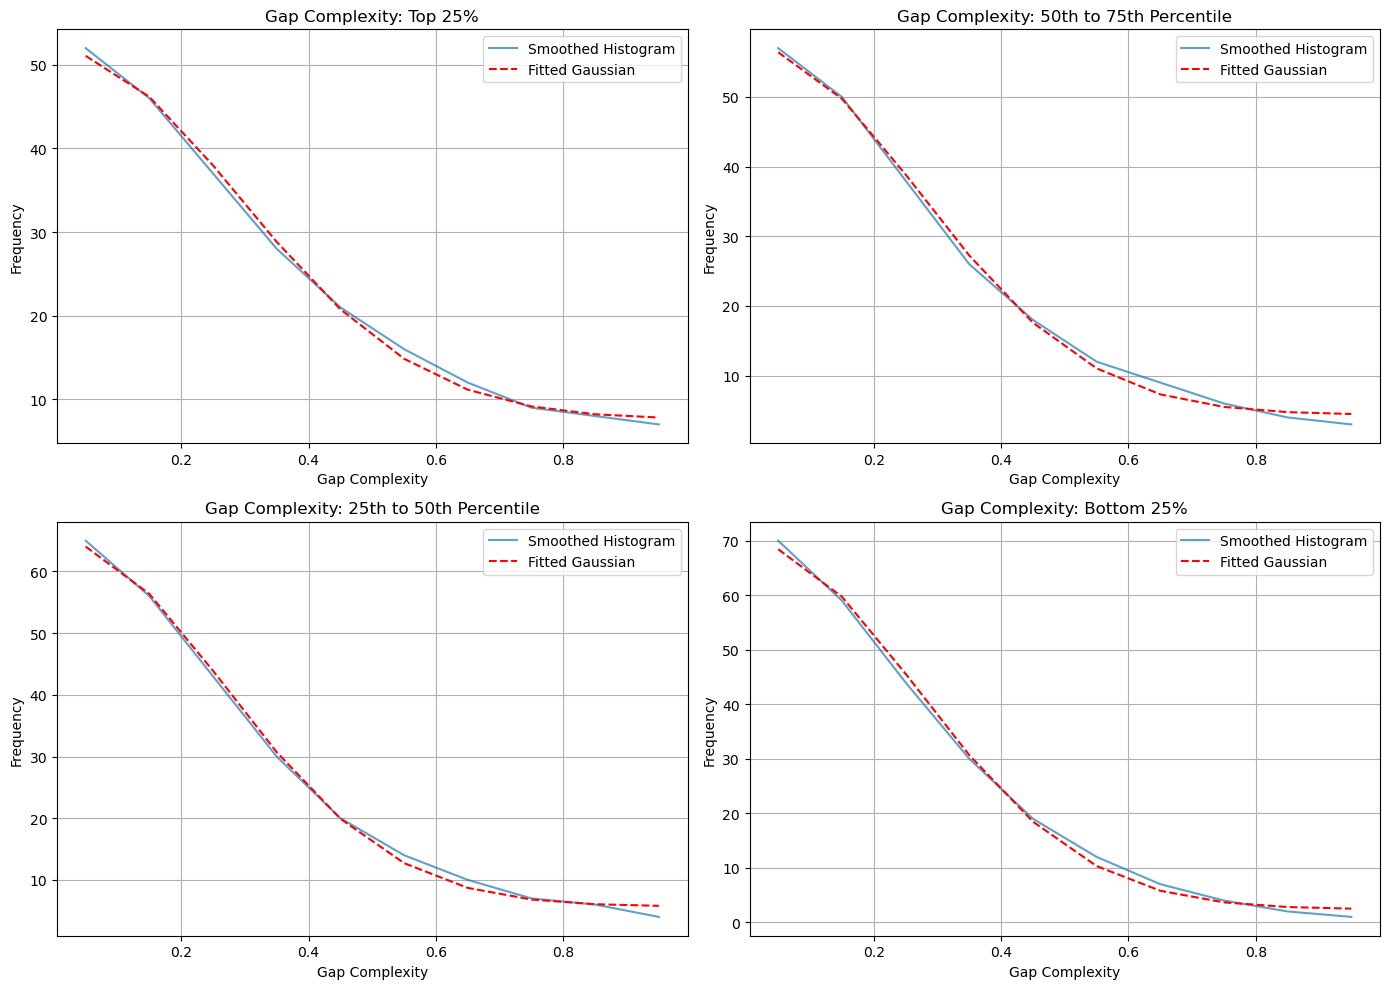

                     Range  Mean    Stddev     Shift
0                  Top 25%     0  0.289150  7.623368
1  50th to 75th Percentile     0  0.270118  4.385840
2  25th to 50th Percentile     0  0.266132  5.694957
3               Bottom 25%     0  0.265958  2.403635


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

# Define a Gaussian function with mean fixed at 0 and a vertical shift
def gaussian_fixed_mean_shift(x, amp, stddev, shift):
    mean = 0
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + shift

# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# List to store the results
results = []

# Plot histograms for each range
for ax, (title, data) in zip(axs.flatten(), ranges):
    counts, bins = np.histogram(data['gap_complexity'], bins=10, range=(0,1))
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian with mean fixed at 0 and a vertical shift to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian_fixed_mean_shift, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.std(bins_center), min(smoothed_counts)], 
        bounds=([0, 0, -np.inf], [np.inf, np.inf, np.inf]), 
        method='trf', 
        maxfev=100000
    )
    
    # Store the results
    results.append({'Range': title, 'Mean': 0, 'Stddev': popt[1], 'Shift': popt[2]})
    
    # Plot the smoothed histogram data
    ax.plot(bins_center, smoothed_counts, alpha=0.7, label='Smoothed Histogram')
    
    # Plot the fitted Gaussian
    ax.plot(bins_center, gaussian_fixed_mean_shift(bins_center, *popt), 'r--', label='Fitted Gaussian')
    
    ax.set_title(f'Gap Complexity: {title}')
    ax.set_xlabel('Gap Complexity')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

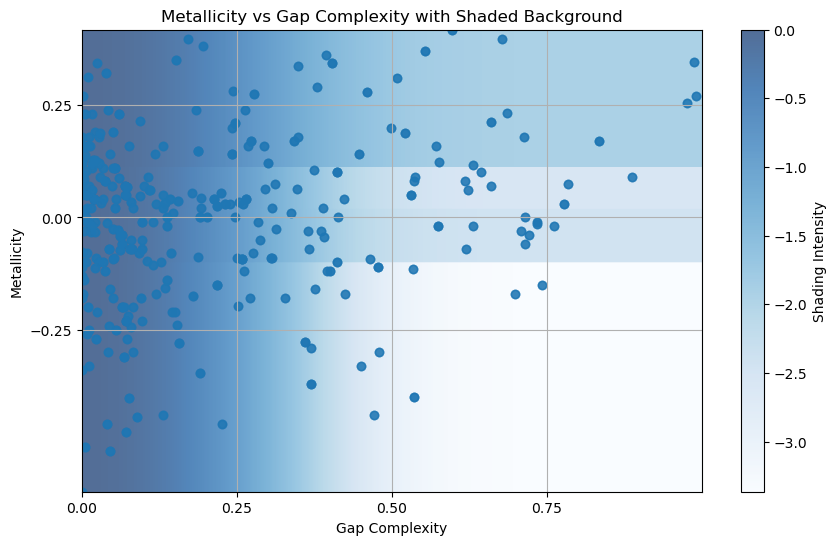

                     Range  Mean    Stddev     Shift        Amp
0                  Top 25%     0  0.289150  7.623368  44.108552
1  50th to 75th Percentile     0  0.270118  4.385840  52.925945
2  25th to 50th Percentile     0  0.266132  5.694957  59.386398
3               Bottom 25%     0  0.265958  2.403635  67.200352


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

# Define a Gaussian function with mean fixed at 0 and a vertical shift
def gaussian_fixed_mean_shift(x, amp, stddev, shift):
    mean = 0
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + shift

# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# List to store the results
results = []

# Fit Gaussians for each range and store the results
for title, data in ranges:
    counts, bins = np.histogram(data['gap_complexity'], bins=10, range=(0,1))
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian with mean fixed at 0 and a vertical shift to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian_fixed_mean_shift, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.std(bins_center), min(smoothed_counts)], 
        bounds=([0, 0, -np.inf], [np.inf, np.inf, np.inf]), 
        method='trf', 
        maxfev=100000
    )
    
    # Store the results
    results.append({'Range': title, 'Mean': 0, 'Stddev': popt[1], 'Shift': popt[2], 'Amp': popt[0]})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot the original gap complexity vs metallicity scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(monostar_systems_df['gap_complexity'], monostar_systems_df['st_met'], alpha=0.5, label='Data')

# Shade the four bins in metallicity
x = np.linspace(0, 1.5, 500)
y = np.linspace(monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max(), 500)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i, (title, data) in enumerate(ranges):
    amp = results_df.loc[i, 'Amp']
    stddev = results_df.loc[i, 'Stddev']
    shift = results_df.loc[i, 'Shift']
    
    # Calculate the shading intensity based on the Gaussian fit
    Z_region = gaussian_fixed_mean_shift(X, amp, stddev, shift)
    
    # Normalize the shading intensity to [0, 1]
    #Z_region = (Z_region - Z_region.min()) / (Z_region.max() - Z_region.min())
    Z_region = (Z_region) / (Z_region.max())
    
    # Apply the shading to the corresponding metallicity range
    if title == 'Top 25%':
        mask = (Y > q3)
    elif title == '50th to 75th Percentile':
        mask = (Y <= q3) & (Y > q2)
    elif title == '25th to 50th Percentile':
        mask = (Y <= q2) & (Y > q1)
    elif title == 'Bottom 25%':
        mask = (Y <= q1)
    
    Z[mask] = Z_region[mask]

# Plot the shaded background
plt.imshow(np.log(Z), extent=[0, 1.0, monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max()], origin='lower', aspect='auto', cmap='Blues', alpha=0.7)

plt.xlabel('Gap Complexity')
plt.ylabel('Metallicity')
plt.title('Metallicity vs Gap Complexity with Shaded Background')
plt.xticks(np.arange(0, 1.0, 0.25))
plt.yticks([-0.25, 0.0, 0.25])
plt.colorbar(label='Shading Intensity')
plt.grid(True)
plt.show()

# Display the table
print(results_df)

In [23]:
q4 = monostar_systems_df['st_met'].quantile(1.0)
q3 = monostar_systems_df['st_met'].quantile(0.75)
q2 = monostar_systems_df['st_met'].quantile(0.5)
q1 = monostar_systems_df['st_met'].quantile(0.25)
q0 = monostar_systems_df['st_met'].quantile(0.0)
print(q4, q3, q2, q1, q0)

bin1 = monostar_systems_df[(monostar_systems_df['st_met'] <= q4) & (monostar_systems_df['st_met'] > q3)]
mean_bin1 = bin1['st_met'].mean()
bin2 = monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]
mean_bin2 = bin2['st_met'].mean()
bin3 = monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]
mean_bin3 = bin3['st_met'].mean()
bin4 = monostar_systems_df[(monostar_systems_df['st_met'] <= q1) & (monostar_systems_df['st_met'] > q0)]
mean_bin4 = bin4['st_met'].mean()

0.4175 0.111 0.02 -0.10000000000000002 -0.61


0.4175 0.111 0.02 -0.10000000000000002 -0.61


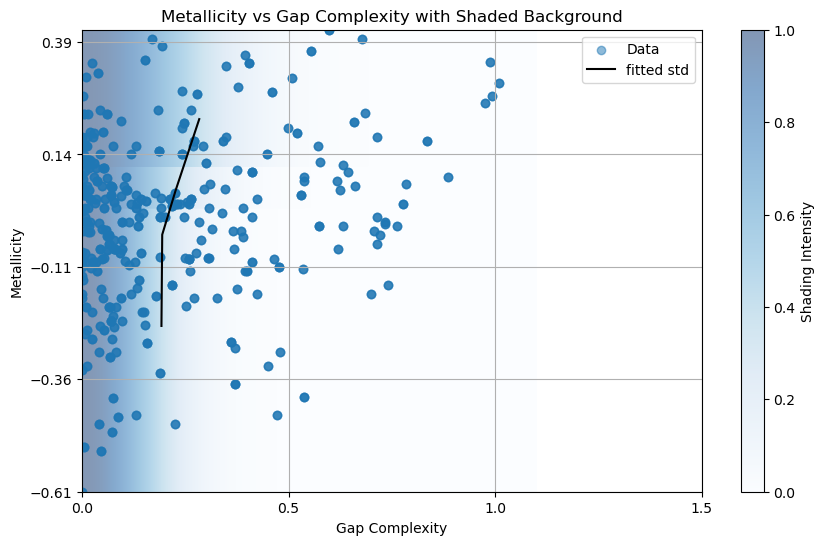

                     Range  Mean    Stddev      Shift        Amp
0                  Top 25%     0  0.283877   8.648903  43.284365
1  50th to 75th Percentile     0  0.226994   6.320766  50.435333
2  25th to 50th Percentile     0  0.194316  10.420446  47.188729
3               Bottom 25%     0  0.192447   6.487623  56.014382


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

# Define a Gaussian function with mean fixed at 0 and a vertical shift
def gaussian_fixed_mean_shift(x, amp, stddev, shift):
    mean = 0
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + shift

# Calculate the quartiles for metallicity
q4 = monostar_systems_df['st_met'].quantile(1.0)
q3 = monostar_systems_df['st_met'].quantile(0.75)
q2 = monostar_systems_df['st_met'].quantile(0.5)
q1 = monostar_systems_df['st_met'].quantile(0.25)
q0 = monostar_systems_df['st_met'].quantile(0.0)
print(q4, q3, q2, q1, q0)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# List to store the results
results = []

# Fit Gaussians for each range and store the results
for title, data in ranges:
    counts, bins = np.histogram(data['gap_complexity'], bins=10)
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian with mean fixed at 0 and a vertical shift to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian_fixed_mean_shift, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.std(bins_center), min(smoothed_counts)], 
        bounds=([0, 0, -np.inf], [np.inf, np.inf, np.inf]), 
        method='trf', 
        maxfev=100000
    )
    
    # Store the results
    results.append({'Range': title, 'Mean': 0, 'Stddev': popt[1], 'Shift': popt[2], 'Amp': popt[0]})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Calculate mean for each bin
mean_bin1 = bin1['st_met'].mean()
mean_bin2 = bin2['st_met'].mean()
mean_bin3 = bin3['st_met'].mean()
mean_bin4 = bin4['st_met'].mean()

# Get stddev from the Gaussian fits
stddev_bin1 = results_df.loc[results_df['Range'] == 'Top 25%', 'Stddev'].values[0]
stddev_bin2 = results_df.loc[results_df['Range'] == '50th to 75th Percentile', 'Stddev'].values[0]
stddev_bin3 = results_df.loc[results_df['Range'] == '25th to 50th Percentile', 'Stddev'].values[0]
stddev_bin4 = results_df.loc[results_df['Range'] == 'Bottom 25%', 'Stddev'].values[0]

# Plot the original gap complexity vs metallicity scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(monostar_systems_df['gap_complexity'], monostar_systems_df['st_met'], alpha=0.5, label='Data')

# Shade the four bins in metallicity
x = np.linspace(0, 1.5, 500)
y = np.linspace(monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max(), 500)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i, (title, data) in enumerate(ranges):
    amp = results_df.loc[i, 'Amp']
    stddev = results_df.loc[i, 'Stddev']
    shift = results_df.loc[i, 'Shift']
    
    # Calculate the shading intensity based on the Gaussian fit
    Z_region = gaussian_fixed_mean_shift(X, amp, stddev, shift)
    
    # Normalize the shading intensity to [0, 1]
    Z_region = (Z_region - Z_region.min()) / (Z_region.max() - Z_region.min())
    
    # Apply the shading to the corresponding metallicity range
    if title == 'Top 25%':
        mask = (Y > q3)
    elif title == '50th to 75th Percentile':
        mask = (Y <= q3) & (Y > q2)
    elif title == '25th to 50th Percentile':
        mask = (Y <= q2) & (Y > q1)
    elif title == 'Bottom 25%':
        mask = (Y <= q1)
    
    Z[mask] = Z_region[mask]

# Plot the shaded background
plt.imshow(Z, extent=[0, 1.1, monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max()], origin='lower', aspect='auto', cmap='Blues', alpha=0.5)

# Plot stddev vs mean metallicity for each bin
plt.errorbar([stddev_bin4, stddev_bin3, stddev_bin2, stddev_bin1], [mean_bin4, mean_bin3, mean_bin2, mean_bin1], 
             color='k', label='fitted std')

plt.xlabel('Gap Complexity')
plt.ylabel('Metallicity')
plt.title('Metallicity vs Gap Complexity with Shaded Background')
plt.xticks(np.arange(0, 1.6, 0.5))
plt.yticks(np.arange(monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max() + 0.1, 0.25))
plt.colorbar(label='Shading Intensity')
plt.legend()
plt.grid(True)
plt.show()

# Display the table
print(results_df)

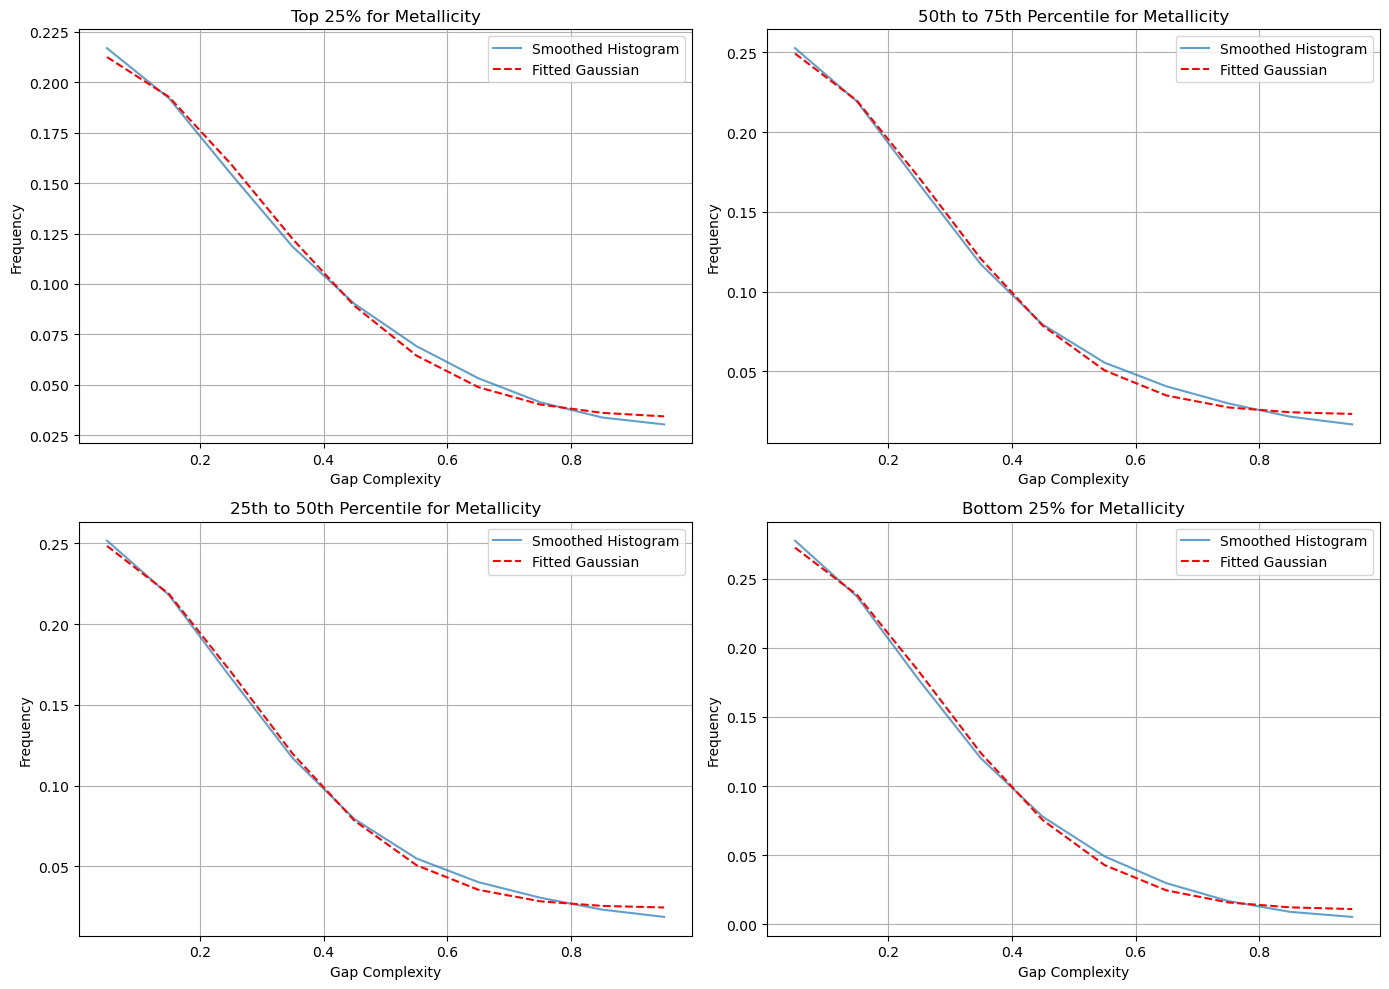

                     Range          Mean    Stddev     Shift
0                  Top 25%  8.089056e-18  0.292542  0.033420
1  50th to 75th Percentile  5.997439e-15  0.267247  0.022877
2  25th to 50th Percentile  1.486193e-16  0.265139  0.024150
3               Bottom 25%  6.342665e-18  0.267724  0.010648


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

# Define a Gaussian function with a vertical shift
def gaussian_shift(x, amp, stddev, mean, shift):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + shift

# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# List to store the results
results = []

# Plot histograms for each range
for ax, (title, data) in zip(axs.flatten(), ranges):
    counts, bins = np.histogram(data['gap_complexity'], bins=10, range=(0, 1))
    counts = counts / counts.sum()  # Normalize the histogram counts
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian with a vertical shift to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian_shift, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.std(bins_center), 0.5, min(smoothed_counts)], 
        bounds=([0, 0, 0, -np.inf], [np.inf, np.inf, 1, np.inf]), 
        method='trf', 
        maxfev=100000
    )
    
    # Store the results
    results.append({'Range': title, 'Mean': popt[2], 'Stddev': popt[1], 'Shift': popt[3]})
    
    # Plot the smoothed histogram data
    ax.plot(bins_center, smoothed_counts, alpha=0.7, label='Smoothed Histogram')
    
    # Plot the fitted Gaussian
    ax.plot(bins_center, gaussian_shift(bins_center, *popt), 'r--', label='Fitted Gaussian')
    
    ax.set_title(f'{title} for Metallicity')
    ax.set_xlabel('Gap Complexity')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

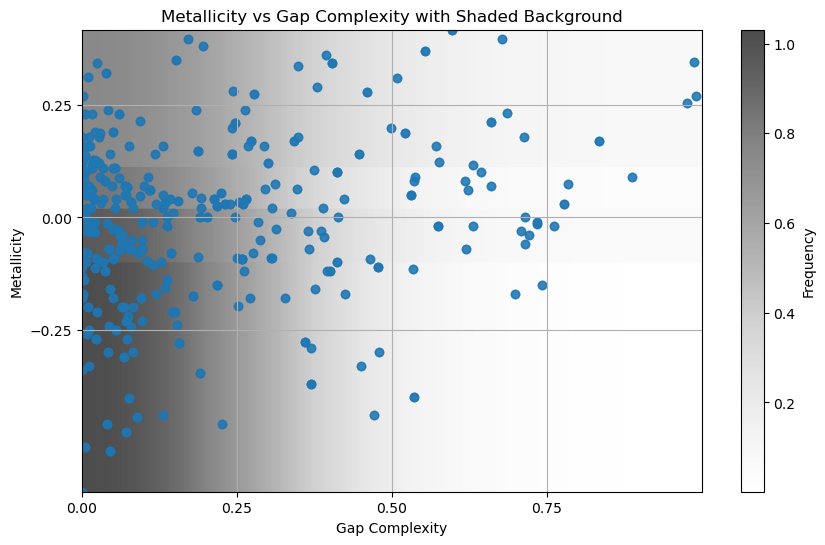

                     Range          Mean    Stddev     Shift        Amp
0                  Top 25%  1.254148e-15  0.289151  7.623358  44.108552
1  50th to 75th Percentile  3.781007e-17  0.270118  4.385837  52.925944
2  25th to 50th Percentile  2.042359e-17  0.266132  5.694960  59.386398
3               Bottom 25%  1.555595e-15  0.265958  2.403637  67.200353


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

# Define a Gaussian function with a vertical shift
def gaussian_shift(x, amp, stddev, mean, shift):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + shift

# Calculate the quartiles for metallicity
q1 = monostar_systems_df['st_met'].quantile(0.25)
q2 = monostar_systems_df['st_met'].quantile(0.50)
q3 = monostar_systems_df['st_met'].quantile(0.75)

# Define the metallicity ranges based on quartiles
ranges = [
    ('Top 25%', monostar_systems_df[monostar_systems_df['st_met'] > q3]),
    ('50th to 75th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q3) & (monostar_systems_df['st_met'] > q2)]),
    ('25th to 50th Percentile', monostar_systems_df[(monostar_systems_df['st_met'] <= q2) & (monostar_systems_df['st_met'] > q1)]),
    ('Bottom 25%', monostar_systems_df[monostar_systems_df['st_met'] <= q1])
]

# List to store the results
results = []

# Fit Gaussians for each range and store the results
for title, data in ranges:
    counts, bins = np.histogram(data['gap_complexity'], bins=10, range=(0, 1))
    bins_center = (bins[:-1] + bins[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    
    # Fit a Gaussian with a vertical shift to the smoothed histogram data
    popt, _ = curve_fit(
        gaussian_shift, bins_center, smoothed_counts, 
        p0=[max(smoothed_counts), np.std(bins_center), 0.5, min(smoothed_counts)], 
        bounds=([0, 0, 0, -np.inf], [np.inf, np.inf, 1, np.inf]), 
        method='trf', 
        maxfev=100000
    )
    
    # Store the results
    results.append({'Range': title, 'Mean': popt[2], 'Stddev': popt[1], 'Shift': popt[3], 'Amp': popt[0]})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot the original gap complexity vs metallicity scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(monostar_systems_df['gap_complexity'], monostar_systems_df['st_met'], alpha=0.5, label='Data')

# Shade the four bins in metallicity
x = np.linspace(0, 1.0, 500)
y = np.linspace(monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max(), 500)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i, (title, data) in enumerate(ranges):
    amp = results_df.loc[i, 'Amp']
    stddev = results_df.loc[i, 'Stddev']
    mean = results_df.loc[i, 'Mean']
    shift = results_df.loc[i, 'Shift']
    
    # Calculate the shading intensity based on the Gaussian fit
    Z_region = gaussian_shift(X, amp, stddev, mean, shift)
    
    # Normalize the shading intensity to [0, 1]
    Z_region = (Z_region - 2.4) / (67.6 - 2.4)
    
    # Apply the shading to the corresponding metallicity range
    if title == 'Top 25%':
        mask = (Y > q3)
    elif title == '50th to 75th Percentile':
        mask = (Y <= q3) & (Y > q2)
    elif title == '25th to 50th Percentile':
        mask = (Y <= q2) & (Y > q1)
    elif title == 'Bottom 25%':
        mask = (Y <= q1)
    
    Z[mask] = Z_region[mask]

# Plot the shaded background
plt.imshow(Z, extent=[0, 1.0, monostar_systems_df['st_met'].min(), monostar_systems_df['st_met'].max()], origin='lower', aspect='auto', cmap='Greys', alpha=0.7)

plt.xlabel('Gap Complexity')
plt.ylabel('Metallicity')
plt.title('Metallicity vs Gap Complexity with Shaded Background')
plt.xticks(np.arange(0, 1.0, 0.25))
plt.yticks([-0.25, 0.0, 0.25])
plt.colorbar(label='Frequency')
plt.grid(True)
plt.show()

# Display the table
print(results_df)

The following two plots are nonsense because I forgot that there are multiple planets represented by each point and so there isn't one radius. That is just plotting the first radius.

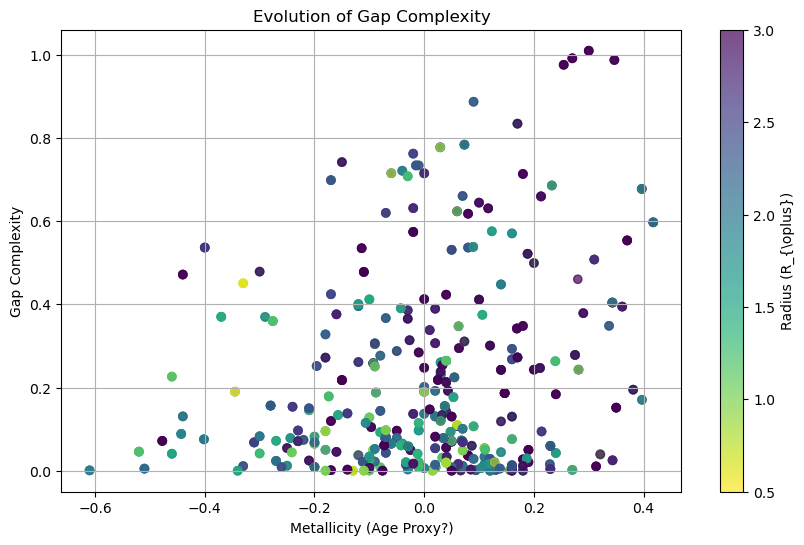

In [27]:
import matplotlib.colors as mcolors

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Normalize the radius values to the range [0, 1]
norm = mcolors.Normalize(vmin=0.5, vmax=3)

# Create a colormap that transitions from green to indigo
cmap = plt.colormaps.get_cmap('viridis').reversed()

# Plot metallicity vs gap complexity with colors based on radius
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['st_met'], monostar_systems_df['gap_complexity'], 
                 c=monostar_systems_df['pl_rade'], cmap=cmap, norm=norm, alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.xlabel('Metallicity (Age Proxy?)')
plt.ylabel('Gap Complexity')
plt.grid(True)


# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Radius (R_{\oplus})")

plt.show()

I tried to scale this so this green is an Earth radii and Neptune is blue.

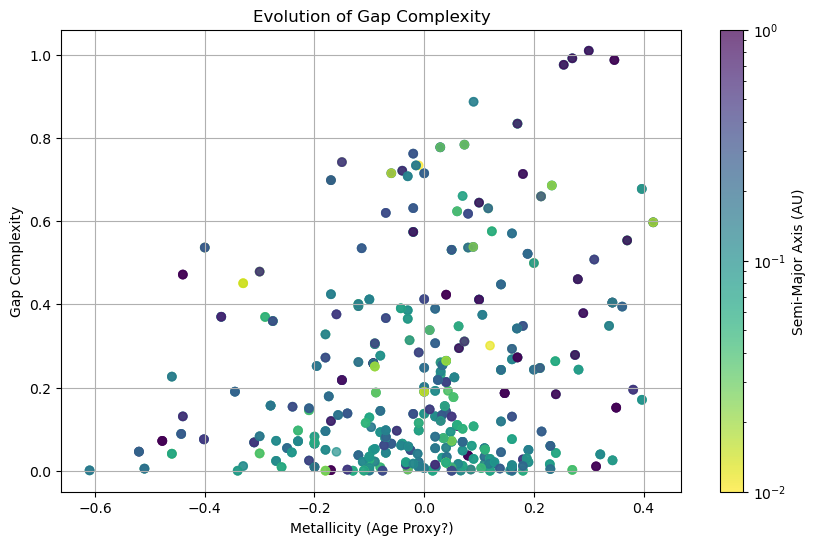

In [28]:
# Normalize the semi-major axis values to a logarithmic scale
norm = mcolors.LogNorm(vmin=0.01, vmax=1)

# Create a colormap that transitions from green to indigo and reverse it
cmap = plt.colormaps.get_cmap('viridis').reversed()

# Plot metallicity vs gap complexity with colors based on semi-major axis
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['st_met'], monostar_systems_df['gap_complexity'], 
                 c=monostar_systems_df['pl_orbsmax'], cmap=cmap, norm=norm, alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.xlabel('Metallicity (Age Proxy?)')
plt.ylabel('Gap Complexity')
plt.grid(True)


# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Semi-Major Axis (AU)")

plt.show()

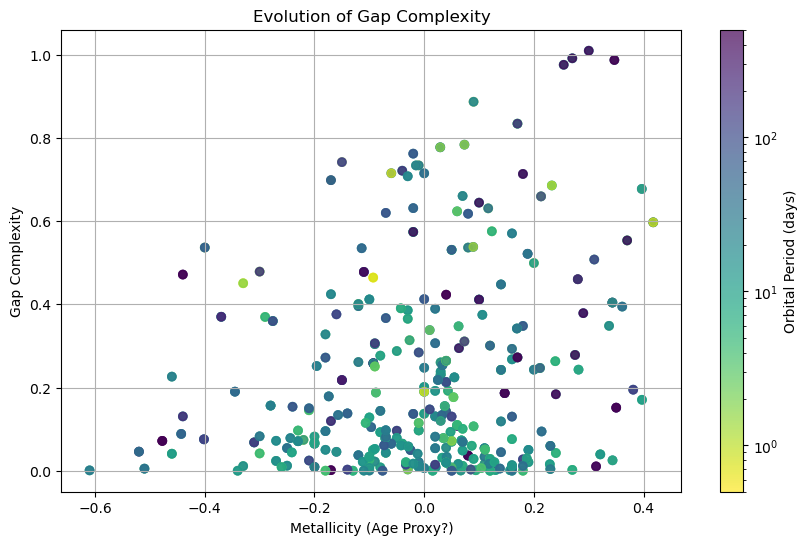

In [29]:
# Normalize the orbital period values to a logarithmic scale
norm = mcolors.LogNorm(vmin=0.5, vmax=500)

# Create a colormap that transitions from green to indigo
cmap = plt.colormaps.get_cmap('viridis').reversed()

# Plot metallicity vs gap complexity with colors based on orbital period
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['st_met'], monostar_systems_df['gap_complexity'], 
                 c=monostar_systems_df['pl_orbper'], cmap=cmap, norm=norm, alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.xlabel('Metallicity (Age Proxy?)')
plt.ylabel('Gap Complexity')
plt.grid(True)


# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Orbital Period (days)")

plt.show()

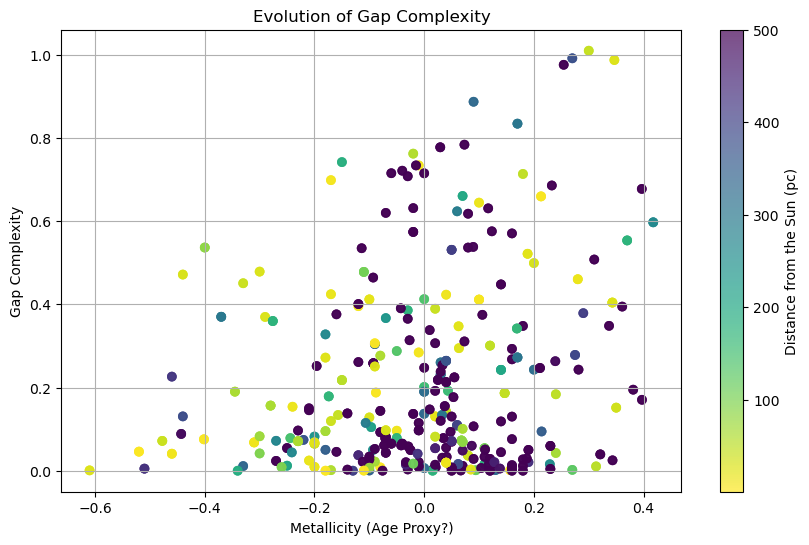

In [30]:
# Normalize the orbital period values to a logarithmic scale
norm = mcolors.Normalize(vmin=0.5, vmax=500)

# Create a colormap that transitions from green to indigo
cmap = plt.colormaps.get_cmap('viridis').reversed()

# Plot metallicity vs gap complexity with colors based on orbital period
plt.figure(figsize=(10, 6))
sc = plt.scatter(monostar_systems_df['st_met'], monostar_systems_df['gap_complexity'], 
                 c=monostar_systems_df['sy_dist'], cmap=cmap, norm=norm, alpha=0.7)
plt.title('Evolution of Gap Complexity')
plt.xlabel('Metallicity (Age Proxy?)')
plt.ylabel('Gap Complexity')
plt.grid(True)
#plt.gca().invert_xaxis()  # Reverse the x-axis direction

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Distance from the Sun (pc)")

plt.show()

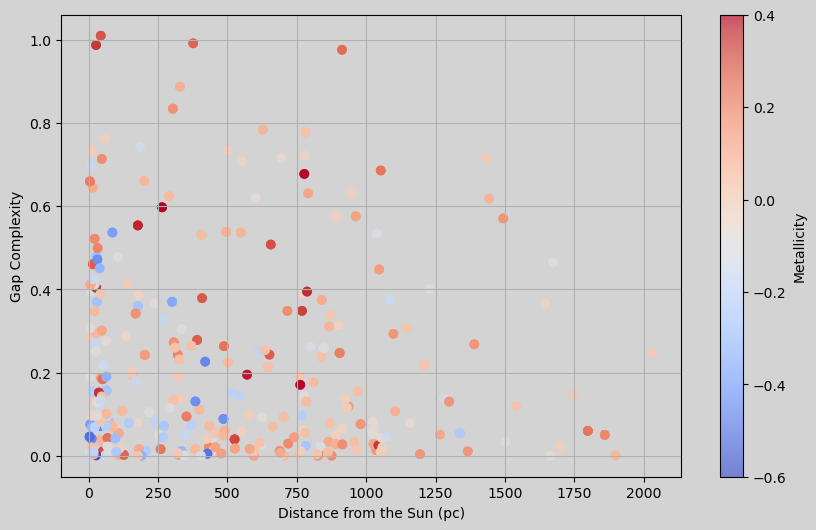

In [31]:
# Normalize the metallicity values to a linear scale
norm = mcolors.Normalize(vmin=-0.6, vmax=0.4)

# Create a colormap that transitions from blue to red
cmap = plt.colormaps.get_cmap('coolwarm')

# Plot gap complexity vs distance from the sun with colors based on metallicity
plt.figure(figsize=(10, 6))

plt.gcf().set_facecolor('lightgrey')  # Set the figure background color to dark grey
ax = plt.gca()
ax.set_facecolor('lightgrey')  # Set the axes background color to dark grey

sc = plt.scatter(monostar_systems_df['sy_dist'], monostar_systems_df['gap_complexity'], 
                 c=monostar_systems_df['st_met'], cmap=cmap, norm=norm, alpha=0.7)
plt.xlabel('Distance from the Sun (pc)')
plt.ylabel('Gap Complexity')
plt.grid(True)

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Metallicity")

plt.show()

## Toy universe stuff
What is the distribution of number of planets with $P<1000$ days?
Is it different for binaries?

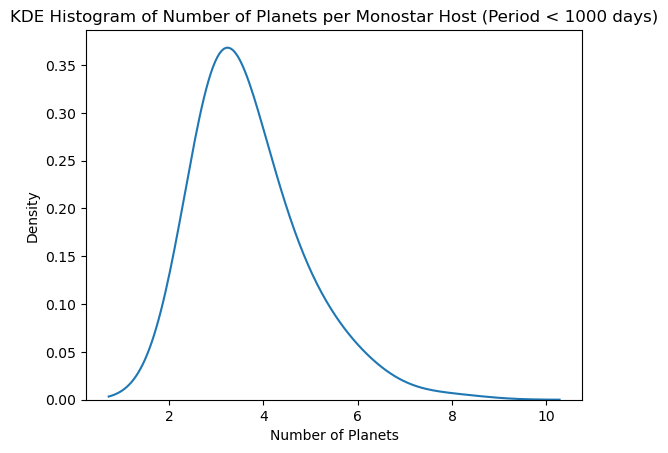

In [43]:
import seaborn as sns

# Filter the data for monostar hosts and planets with periods < 1000 days
monostar_systems_df_Pfiltered = monostar_systems_df[monostar_systems_df['pl_orbper'] < 1000]

# Create the KDE histogram
sns.kdeplot(monostar_systems_df_Pfiltered['sy_pnum'], label='singular hosts', bw_adjust=3)

# Set the plot labels and title
plt.xlabel('Number of Planets')
plt.ylabel('Density')
plt.title('KDE Histogram of Number of Planets per Monostar Host (Period < 1000 days)')

# Show the plot
plt.show()


I think I manually made the 3 planet cut

In [47]:
# getting a fresh copy of the data
toy_df = exoplanet_df[['hostname', 'sy_pnum', 'sy_snum', 'pl_orbper', 'st_met', 'pl_name', 'pl_rade'\
                                      , 'st_meterr1', 'st_meterr2', 'pl_orbpererr1', 'pl_orbpererr2'\
                                      , 'pl_radeerr1', 'pl_radeerr2'\
                                      , 'sy_pm', 'sy_pmerr1', 'sy_pmerr2', 'sy_dist', 'sy_disterr1', 'sy_disterr2'\
                                      , 'ra', 'dec'\
                                      , 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2'\
                                      , 'pl_masse', 'pl_masseerr1', 'pl_masseerr2'\
                                      , 'pl_trueobliq', 'pl_trueobliqerr1', 'pl_trueobliqerr2']]

#filtered_exoplanet_df = filtered_exoplanet_df[(filtered_exoplanet_df['sy_pnum'] >= 3) & (filtered_exoplanet_df['sy_pnum'] <= 8)]
# yip, I did make the cut manually.
toy_df = toy_df[toy_df['sy_pnum'] >= 1]  # this probably does nothing

# Apply the function to the DataFrame  <- what function? who knows. 
toy_df = process_planet_entries(toy_df)

# Make my P cut
toy_df = toy_df[toy_df['pl_orbper'] < 1000]

# Split into different DataFrames based on the number of stars (sy_snum)
toy_df_snum1 = toy_df[toy_df['sy_snum'] == 1]  # singular hosts
toy_df_snum2 = toy_df[toy_df['sy_snum'] == 2]  # binaries

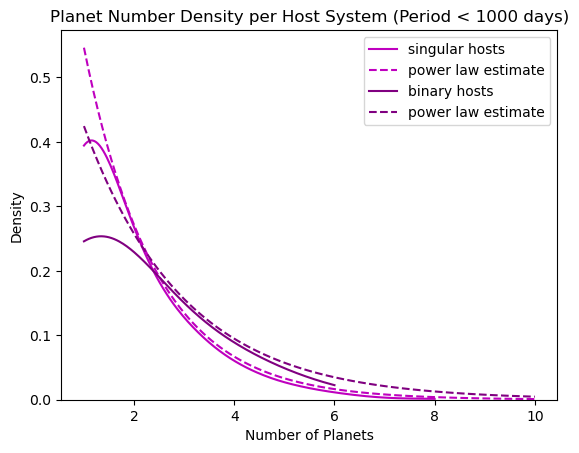

In [126]:
A_snum1, decay_snum1 = 1.1, 0.7
A_snum2, decay_snum2 = 0.7, 0.5
num = np.linspace(1, 10, 100)

# Create the KDE histogram
sns.kdeplot(toy_df_snum1['sy_pnum'], label='singular hosts', bw_adjust=3, cut=0, color='m')
# Make a Gaussian estimate of the KDE
plt.plot(num, A_snum1*np.exp(-decay_snum1*num), 'm--', label='power law estimate')

# Binaries
sns.kdeplot(toy_df_snum2['sy_pnum'], label='binary hosts', bw_adjust=3, cut=0, color='purple')
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
plt.plot(num, A_snum2*np.exp(-decay_snum2*num), '--', label='power law estimate', color='purple')

# Set the plot labels and title
plt.xlabel('Number of Planets')
plt.ylabel('Density')
plt.title('Planet Number Density per Host System (Period < 1000 days)')
plt.legend()

# Show the plot
plt.show()


Obviously there are detection biases here, but at least this prior is grounded in something empirical. Lets buils the prior arrays.

In [121]:
N = np.arange(10)+1  # integer array from 1 to 10
# Probability of a number of planes in the system given that the host is singular
P_pnum_snum1 = A_snum1 * np.exp(-decay_snum1 * N)
P_pnum_snum2 = A_snum2 * np.exp(-decay_snum2 * N)
P_pnum_snum1 /= np.sum(P_pnum_snum1) # normalize
P_pnum_snum2 /= np.sum(P_pnum_snum2) # normalize
print(N)
print(P_pnum_snum1, np.sum(P_pnum_snum1), np.sum(P_pnum_snum1 * N))
print(P_pnum_snum2, np.sum(P_pnum_snum2), np.sum(P_pnum_snum2 * N))
print(np.sum(P_pnum_snum2 * N)/np.sum(P_pnum_snum1 * N))


[ 1  2  3  4  5  6  7  8  9 10]
[0.50387417 0.25021651 0.12425384 0.06170263 0.03064062 0.01521568
 0.00755588 0.00375214 0.00186326 0.00092527] 0.9999999999999999 1.9773067211022457
[0.3961385  0.24027015 0.14573121 0.08839045 0.05361152 0.03251703
 0.01972257 0.01196235 0.00725553 0.0044007 ] 1.0 2.473657533473756
1.2510236813916358


The binary star priors are making planets more efficiently than the singulars:

$$ \Gamma = 1.25. $$

I think I need to draw fewer binaries to make up for it. Or I could give them bith the same distribution and ignore the problem.

I'm doing that. They can both have the binary density because it looks more reasonable to me.